# Homework 6

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column 'JAMB_Score').

In [1]:
#Dataset
#In this homework, we will use the Students Performance in 2024 JAMB dataset from Kaggle.
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

--2024-11-05 19:50:49--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 20.26.156.215
Connecting to github.com (github.com)|20.26.156.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-05 19:50:49--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382.33K  --.-KB/s    in 0.08s   

2024-11-05 19:50:50 (4.52 MB/s) -

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [13]:
#First, let's make the names lowercase:
df = pd.read_csv('jamb_exam_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [14]:
df.columns

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'student_id', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

In [15]:
#Preparation:
#Remove the student_id column.
df = df.drop('student_id', axis=1)

#Fill missing values with zeros.
df = df.fillna(0)

In [16]:

#Do train/validation/test split with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split
#Use the train_test_split function and set the random_state parameter to 1.

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']


In [17]:

features = ['study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed']

In [18]:
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [19]:
from sklearn.feature_extraction import DictVectorizer

In [20]:
#Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1
Let's train a decision tree regressor to predict the jamb_score variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

- study_hours_per_week

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text


In [22]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [23]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2
Train a random forest regressor with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on the validation data?

42.13




In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

42.13724207871227

## Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

80


In [37]:
!pip install tqdm


  Using cached tqdm-4.66.6-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.6-py3-none-any.whl (78 kB)


In [28]:
from tqdm.auto import tqdm

In [29]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

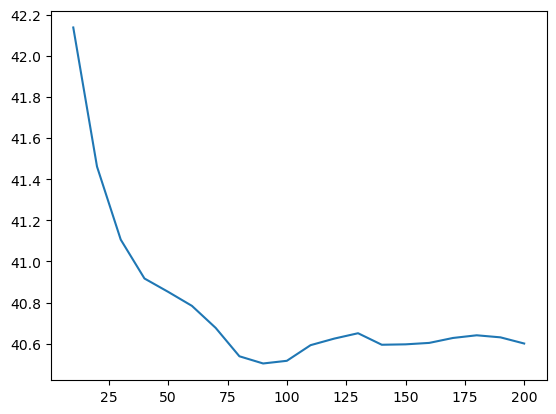

In [30]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

## Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?

10


In [31]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

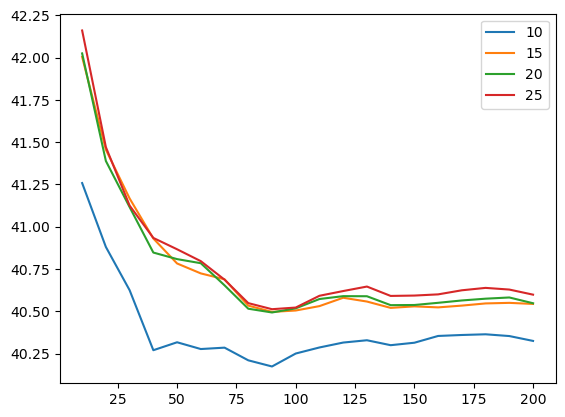

In [32]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

## Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)
Get the feature importance information from this model

What's the most important feature (among these 4)?

- study_hours_per_week

In [33]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [34]:
rf.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [35]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

In [49]:
#Install XGBoost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 3.4 MB/s eta 0:00:0000:0100:02


In [36]:
import xgboost as xgb

#Create DMatrix for train and validation

features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [37]:
#Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [38]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [39]:
scores = {}

In [40]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
#Train a model with these parameters for 100 rounds:
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [41]:
scores['eta=0.3'] = parse_xgb_output(output)

In [42]:
%%capture output 

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [43]:
scores['eta=0.1'] = parse_xgb_output(output) #Now change eta to 0.1

## Which eta leads to the best RMSE score on the validation dataset?
0.1

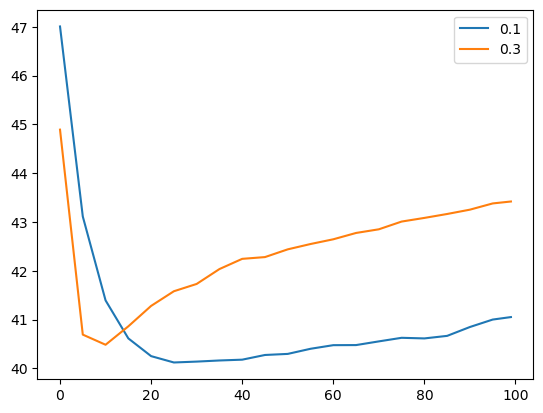

In [44]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()